<a href="https://colab.research.google.com/github/duonghung86/Vehicle-trajectory-tracking/blob/master/Codes/VTP_1_10_Models_for_full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing models for full dataset
---

## Import packages

In [1]:
# General
import numpy as np
import time
import os

# Loading datasets
from io import StringIO, BytesIO
from zipfile import ZipFile
import urllib.request

# For data processing
import pandas as pd
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt

# For prediction model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

## Load dataset

In [2]:
def url2pd(link):
    with ZipFile(link) as my_zip_file:
        for contained_file in my_zip_file.namelist():
            fzip=my_zip_file.open(contained_file)
            data=fzip.read()
    s=str(data,'utf-8')
    data = StringIO(s) 
    print('Done loading a dataset!')
    return pd.read_csv(data)

In [3]:
filenames = os.listdir('./Data')
url_1 = './Data/' + filenames[4]
df = url2pd(url_1)
df.info()
df.head(3)

Done loading a dataset!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Vehicle_ID     1048575 non-null  int64  
 1   Frame_ID       1048575 non-null  int64  
 2   Total_Frames   1048575 non-null  int64  
 3   Global_Time    1048575 non-null  int64  
 4   Local_X        1048575 non-null  float64
 5   Local_Y        1048575 non-null  float64
 6   Global_X       1048575 non-null  float64
 7   Global_Y       1048575 non-null  float64
 8   v_Length       1048575 non-null  float64
 9   v_Width        1048575 non-null  float64
 10  v_Class        1048575 non-null  int64  
 11  v_Vel          1048575 non-null  float64
 12  v_Acc          1048575 non-null  float64
 13  Lane_ID        1048575 non-null  int64  
 14  Preceding      1048575 non-null  int64  
 15  Following      1048575 non-null  int64  
 16  Space_Headway  1048575 non-nul

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway
0,284,63,526,1113436773200,41.375,66.469,6042864.125,2133138.844,15.4,5.9,2,44.55,0.0,4,0,0,0.0,0.0
1,284,64,526,1113436773300,41.375,71.069,6042863.571,2133143.309,15.4,5.9,2,44.55,0.0,4,0,0,0.0,0.0
2,284,65,526,1113436773400,41.374,75.570,6042863.016,2133147.775,15.4,5.9,2,44.55,0.0,4,0,0,0.0,0.0


Let's take a glance at the data. Here are the first few rows:

In [4]:
# Filter time step
print(df.shape)
df = df.iloc[::2,:].copy()
df.reset_index(drop=True, inplace=True)
print('After filtering:', df.shape)
#  keep only columns that are useful for now
kept_cols = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Local_X','Local_Y','v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID']
df = df[kept_cols]
df.head()

(1048575, 18)
After filtering: (524288, 18)


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,284,63,526,41.375,66.469,15.4,5.9,2,44.55,0.00,4
1,284,65,526,41.374,75.570,15.4,5.9,2,44.55,0.00,4
2,284,67,526,41.372,84.607,15.4,5.9,2,44.55,-6.14,4
3,284,69,526,41.369,93.368,15.4,5.9,2,43.00,-7.12,4
4,284,71,526,41.376,101.844,15.4,5.9,2,43.84,11.20,4


In [5]:
'the number of vehicles is {}'.format(len(df.Vehicle_ID.unique()))

'the number of vehicles is 1993'

# Model 1

### Constant values

In [6]:
# Set constant values
HISTORY_LENGTH = 3
FUTURE_LENGTH = 5
n_steps = int(HISTORY_LENGTH/0.2)
n_future = int(FUTURE_LENGTH/0.2)
n_features = len(df)
series_feature_names = ['Local_X','v_Vel']
target_names = ['Local_X','v_Vel']
n_labels = len(target_names)
vehicle_ids = df.Vehicle_ID.unique()

## Data preparation

### `series2seq`: Function that return sequence input and output for one object

**Arguments**:
series,past=4,future=1,past_step=1, future_step=1
- series:  A Sequence of observations as a numpy array or list.
- past: Number of lag observations as input (X).
- future: Number of observations as output (y).
- past_step, future_step: increments of input or output
    
**Returns**:
- X, Y: Features and Labels Numpy array

  

In [7]:
# Test data frame
# data set of the vehicle #2
df_test = df[df.Vehicle_ID==vehicle_ids[0]].copy()
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 218
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vehicle_ID    219 non-null    int64  
 1   Frame_ID      219 non-null    int64  
 2   Total_Frames  219 non-null    int64  
 3   Local_X       219 non-null    float64
 4   Local_Y       219 non-null    float64
 5   v_Length      219 non-null    float64
 6   v_Width       219 non-null    float64
 7   v_Class       219 non-null    int64  
 8   v_Vel         219 non-null    float64
 9   v_Acc         219 non-null    float64
 10  Lane_ID       219 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 20.5 KB


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
2,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2
3,2,19,437,16.342611,59.385676,14.5,4.9,2,40.063334,0.676072,2
4,2,21,437,16.304035,67.409629,14.5,4.9,2,40.121870,0.032792,2


In [8]:
def single_series2seq(series,past=4,future=1,past_step=1, future_step=1):
    # length of sequences 
    length = past + future
    seq = series.copy()
    # add rolled series
    for i in range(length-1):
        seq = np.vstack((seq,np.roll(series,i+1)))
    seq = np.flip(seq.T,1)
    seq = seq[length-1:,:]
    # Prepare output
    X = seq[:,:past:past_step]
    Y = seq[:,past::future_step]
    return X,Y
data = np.arange(10)
single_series2seq(data,past = 3, future = 4,future_step=2)

(array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]]),
 array([[3, 5],
        [4, 6],
        [5, 7],
        [6, 8]]))

In [15]:
inputs, labels = single_series2seq(df_test.Local_X,past = n_steps, future = n_future,future_step=5)
df_test.Local_X.shape, inputs.shape, labels.shape

((219,), (180, 15), (180, 5))

In [10]:
def multi_series2seq(mulseries,**kwarg):
    # number of series
    n_series = mulseries.shape[1]
    seq = mulseries.copy()
    X,Y = single_series2seq(seq[:,0],past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
    for i in range(1,n_series):
        newX,newY = single_series2seq(seq[:,i],past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
        X = np.column_stack((X,newX))
        Y = np.column_stack((Y,newY))
    return X,Y
data = np.arange(20).reshape(-1,2)
multi_series2seq(mulseries = data,past = 3, future = 4,future_step=1)

(array([[ 0,  2,  4,  1,  3,  5],
        [ 2,  4,  6,  3,  5,  7],
        [ 4,  6,  8,  5,  7,  9],
        [ 6,  8, 10,  7,  9, 11]]),
 array([[ 6,  8, 10, 12,  7,  9, 11, 13],
        [ 8, 10, 12, 14,  9, 11, 13, 15],
        [10, 12, 14, 16, 11, 13, 15, 17],
        [12, 14, 16, 18, 13, 15, 17, 19]]))

In [18]:
inputs, labels = multi_series2seq(df_test[['Local_X','v_Vel']].values ,past = n_steps, future = n_future,future_step=5)
df_test[['Local_X','v_Vel']].shape, inputs.shape, labels.shape

((219, 2), (180, 30), (180, 10))

### `treatment_cars` Function to prepare the data set for each car

In [19]:
# Test data frame
# data set of the first 5 vehicles
df_test = df[df.Vehicle_ID.isin(vehicle_ids[:5])].copy()
df_test.info()
print(df_test.Vehicle_ID.unique())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vehicle_ID    1023 non-null   int64  
 1   Frame_ID      1023 non-null   int64  
 2   Total_Frames  1023 non-null   int64  
 3   Local_X       1023 non-null   float64
 4   Local_Y       1023 non-null   float64
 5   v_Length      1023 non-null   float64
 6   v_Width       1023 non-null   float64
 7   v_Class       1023 non-null   int64  
 8   v_Vel         1023 non-null   float64
 9   v_Acc         1023 non-null   float64
 10  Lane_ID       1023 non-null   int64  
dtypes: float64(6), int64(5)
memory usage: 95.9 KB
[2 4 5 6 8]


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
2,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2
3,2,19,437,16.342611,59.385676,14.5,4.9,2,40.063334,0.676072,2
4,2,21,437,16.304035,67.409629,14.5,4.9,2,40.121870,0.032792,2


In [40]:
# multiple objects
def multi_obj2seq(data, **kwarg):
    veh_ids = data.Vehicle_ID.unique()
    X,Y = np.array([]), np.array([])
    for id in veh_ids:
        dat = data[data.Vehicle_ID==id][target_names].copy()
        newX,newY = multi_series2seq(dat.values ,past = kwarg['past'],future = kwarg['future'],
                           future_step = kwarg['future_step'])
        #print(X.shape, newX.shape)
        X = np.vstack((X,newX)) if X.size else newX
        Y = np.vstack((Y,newY)) if Y.size else newY
        #print(X.shape)
    if kwarg["show_result"]:
        print(X.shape)
        print(Y.shape)
    return X, Y
inputs, labels = multi_obj2seq(df_test,past = n_steps, future = n_future,future_step=5, show_result=True)

(828, 30)
(828, 10)


### Choose the size of the raw data set

In [41]:
inputs, labels = multi_obj2seq(df,past = n_steps, future = n_future,future_step=5, show_result=True)

(446561, 30)
(446561, 10)


### Split the data set


In [42]:
X_train, X_test, y_train, y_test = train_test_split(inputs,labels, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(312592, 30) (133969, 30) (312592, 10) (133969, 10)


In [44]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.mean(), X_train.std()

(312592, 30)


(-7.233181331552681e-16, 1.0)

In [46]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))


In [48]:
X_train.shape,X_test.shape

((312592, 30, 1), (133969, 30, 1))

## Prediction model

In [49]:
%%time
# define model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1],1)))
model.add(Dense(n_labels*5))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=50, batch_size= 1024,
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
306/306 [==============================] - 7s 11ms/step - loss: 1109.5422 - mse: 1109.5422 - val_loss: 527.9229 - val_mse: 527.9229
Epoch 2/50
306/306 [==============================] - 3s 10ms/step - loss: 447.9933 - mse: 447.9933 - val_loss: 298.7959 - val_mse: 298.7959
Epoch 3/50
306/306 [==============================] - 3s 10ms/step - loss: 276.5678 - mse: 276.5678 - val_loss: 222.1022 - val_mse: 222.1022
Epoch 4/50
306/306 [==============================] - 3s 10ms/step - loss: 201.0358 - mse: 201.0358 - val_loss: 138.3177 - val_mse: 138.3177
Epoch 5/50
306/306 [==============================] - 3s 10ms/step - loss: 124.2522 - mse: 124.2522 - val_loss: 92.4925 - val_mse: 92.4925
Epoch 6/50
306/306 [==============================] - 3s 10ms/step - loss: 83.7055 - mse: 83.7055 - val_loss: 64.4817 - val_mse: 64.4817
Epoch 7/50
306/306 [==============================] - 3s 10ms/step - loss: 57.2953 - mse: 57.2953 - val_loss: 42.6447 - val_mse: 42.6447
Epoch 8/50
306/306 [=

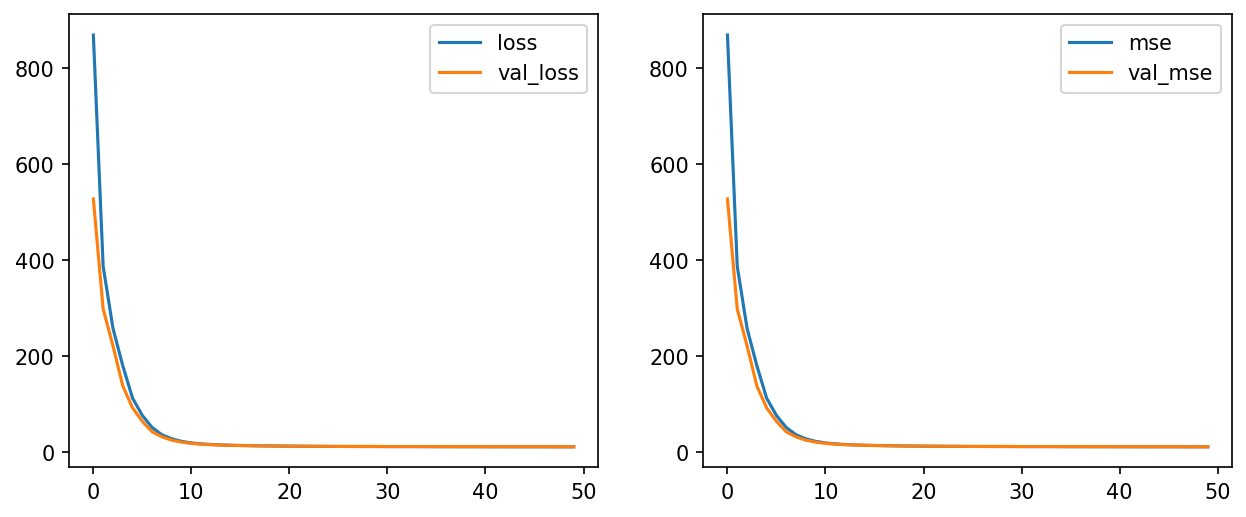

,loss,mse,val_loss,val_mse,epoch
45,11.476357,11.476357,11.612696,11.612696,45
46,11.463804,11.463804,11.535484,11.535484,46
47,11.442630,11.442630,11.486606,11.486606,47
48,11.425872,11.425872,11.464363,11.464363,48
49,11.402305,11.402305,11.478286,11.478286,49


In [50]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()

## Evaluation 


In [52]:
loss, mse = model.evaluate(X_test,y_test, verbose=1)
sqrt(mse)

4187/4187 [==============================] - 10s 2ms/step - loss: 11.4783 - mse: 11.4783


3.387959922733638

In [53]:
y_hat = model.predict(X_test, verbose=1)

4187/4187 [==============================] - 7s 2ms/step


In [59]:
y_test.shape

(133969, 10)

In [67]:
colnames = [str(i)+'s' for i in range(1,6)]
rmse = np.sqrt(np.square(np.subtract(y_test,y_hat)).mean(0)).reshape(2,-1)
rmse = pd.DataFrame(rmse,columns = colnames, index = target_names )
rmse.round(3)

,1s,2s,3s,4s,5s
Local_X,0.60,0.895,1.214,1.503,1.773
v_Vel,0.71,3.426,4.443,5.560,6.621


# END